In [ ]:
# To access via colab
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/wsb data/combined data'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/5153: Applied Machine Learning/wsb data/combined data


In [ ]:
!pip install texthero==1.1.0 -q
!pip install demoji
import texthero as hero

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import demoji
import texthero as hero
from texthero import stopwords

pd.set_option('display.max_colwidth', 50)

%matplotlib inline

In [ ]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [ ]:
# Unzip file from Gdrive
!unzip combined_comments.csv.zip
df = pd.read_csv('./combined_comments.csv', sep = ',')

Archive:  combined_comments.csv.zip
  inflating: combined_comments.csv   
replace __MACOSX/._combined_comments.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._combined_comments.csv  


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Unzip in colab
#df = pd.read_csv('./combined_data/combined_comments.csv', sep = ',')
df=df.reset_index()

## 1. Text Preprocessing

In [ ]:
# Filter out comments w
print('Length of df before removal of dead comments: {}'.format(len(df)))
df = df[~(df['body'] == '[removed]')]
print('Length of df after removal of dead comments: {}'.format(len(df)))

Length of df before removal of dead comments: 1092980
Length of df after removal of dead comments: 810189


In [ ]:
def find_pos(word):
    # Part of Speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos= nltk.pos_tag(nltk.word_tokenize(word))[0][1]
    # Adjective tags -'JJ', 'JJR', 'JJS'
    if pos.lower()[0] == 'j':
        return 'a'
    # Adverb tags -'RB', 'RBR', 'RBS'
    elif pos.lower()[0] == 'r':
        return 'r'
    # Verb tags -'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
    elif pos.lower()[0] == 'v':
        return 'v'
    # Noun tags -'NN', 'NNS', 'NNP', 'NNPS'
    else:
        return 'n'

demoji.download_codes()

def remove_emoji(text):
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, ':'+ dem[item].replace(" ", "")+':'+' ') # replace with emoji mapping and additional space
        
    return text

# Function to apply lemmatization to a list of words
def words_lemmatizer(text, encoding="utf8"):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl= WordNetLemmatizer()
    for word in words:
        pos= find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

def do_preprocessing(df_series):
    custom_pipeline = [hero.preprocessing.fillna, #remove NA
                          hero.preprocessing.lowercase, # lowercase
                          hero.preprocessing.remove_urls,
                          hero.preprocessing.remove_digits, # remove numbers
                          hero.preprocessing.remove_punctuation # remove punctuation
                          ] 
    df_series = df_series.pipe(hero.clean, custom_pipeline)

    df_series = df_series.apply(remove_emoji) # Remove emojis

     # add custom stopwords
    default_stopwords = stopwords.DEFAULT
    new_words = ['already','also','comment','delete','even','literally','lolol','lololol','lolz','lols','lot','loll','lolololol','lolll','mean','na',
                'point','post','probably','put','reddit','remove','see','something','want','well']
    custom_stopwords = default_stopwords.union(set(new_words))
    df_series = hero.preprocessing.remove_stopwords(df_series, custom_stopwords) # remove stopwords
    lemmatize_text = df_series.apply(words_lemmatizer)
    
    df_series = hero.preprocessing.remove_whitespace(df_series) # remove redundant whitespace as the last step
    
    return df_series

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.


In [ ]:
print('Test function, inspect "BEFORE"')
df['body'][10:15]

Test function, inspect "BEFORE"


20                                     Ps I am retarded
21    Finally convinced my wife's boyfriend to let m...
22                                  AMC 💎👐💎👐🚀🚀🚀🚀🚀🛰️🛰️🛰️
23                                          And my axe!
25    Should  invest in AMC tomorrow or did the bull...
Name: body, dtype: object

In [ ]:
print('Test function, inspect "AFTER"')
do_preprocessing(df['body'][10:15])

Test function, inspect "AFTER"


20                                          ps retarded
21    finally convinced wife boyfriend let gambling ...
22    amc :gemstone: :openhands: :gemstone: :openhan...
23                                                  axe
25              invest amc tomorrow bullshit today ruin
Name: body, dtype: object

In [ ]:
# # Preprocessing
# # change to string
# df['body'] = df['body'].astype(str)
# df['body'] = do_preprocessing(df['body'])

In [ ]:
# df.to_csv('text_preprocessed.csv')

## 2. Exploratory Data Analysis

In [ ]:
df_all = pd.read_csv('processed/text_preprocessed.csv')
df_lab = pd.read_csv('tags_only.csv')

df = df_lab.merge(df_all, how = 'inner', on = 'id') # join labels to the preprocessed comments

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Convert to string
df_all['body'] = df_all['body'].astype(str)
df['body'] = df['body'].astype(str)
df['body'][0:5]

0    thanks lost look amcs business page :manshrugg...
1    awesome :smilingfacewithsunglasses: moon :thin...
2    look amcs business page find actually business...
3    bought today retarded dumb money ape germany d...
4    ahh fellow retard people getting pessimistic g...
Name: body, dtype: object

### Create Dictionary to Inspect Words

In [ ]:
# # Create dictionary from ALL COMMENTS
# processed = df_all['body'].apply(str.split)

# # Create a complete corpus from list of texts

# # Split corpus into list of words
# words = []
# for i in processed:
#   words += i

# # Create dictionary
# from collections import Counter
# my_counter = Counter(words)

# # Send to df and export to csv
# counts_df = pd.DataFrame.from_dict(my_counter, orient='index').reset_index()
# counts_df.to_csv('processed/dictionary.csv')

### Create Word Cloud to Inspect Words

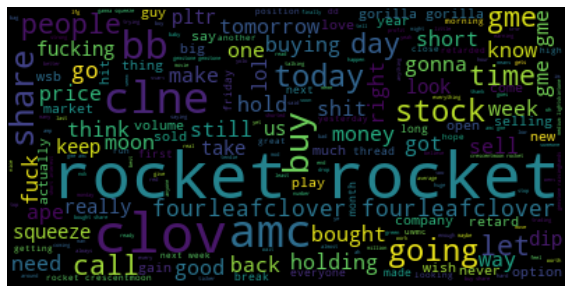

In [ ]:
#word cloud for all posts

stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(text for text in df['body'])
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloud11.png')
plt.show()

In [ ]:
# split df - positive and negative sentiment:
positive = df[df['sentiment'] == 1]
neutral = df[df['sentiment'] == 0]
negative = df[df['sentiment'] == -1]

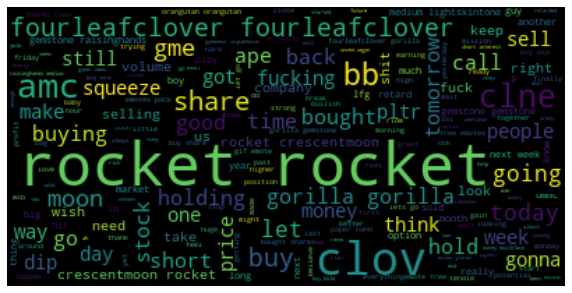

In [ ]:
#wordcloud for positive sentiment posts only

stopwords = set(STOPWORDS)
stopwords.update(["br", "href"]) 
pos = " ".join(review for review in positive['body']) 
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

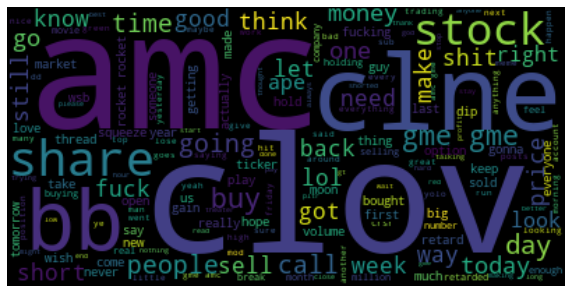

In [ ]:
#wordcloud for neutral posts
neu = " ".join(review for review in neutral['body'])
wordcloud3 = WordCloud(stopwords=stopwords).generate(neu)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloud33.png')
plt.show()